# **Loading the Oxford IIIT Pet Dataset**

In [0]:
# !pip install tensorflow==2.1.0

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (64, 64))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (64, 64))

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (64, 64))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (64, 64))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask


In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4518903583182923892, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14302219786209713485
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12566625398558566668
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5177383287861847620
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [0]:
train = dataset['train'].map(load_image_train, 
                             num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)


In [0]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=
                                       tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)


# **Visualising Test Data**

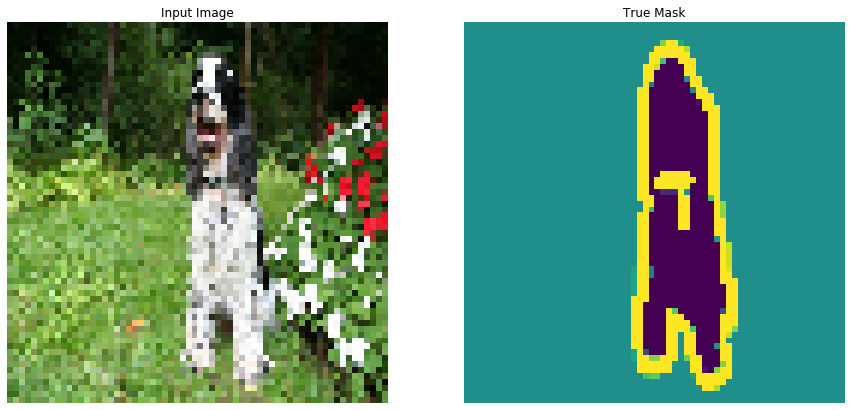

In [0]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img

for image, mask in train.take(2):
  sample_image, sample_mask = image, mask

plt.figure(figsize=(15, 15))
title = ['Input Image', 'True Mask', 'Predicted Mask']

display_list = [sample_image, sample_mask]
for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(array_to_img(display_list[i]))
    plt.axis('off')

plt.show()


# **Building the Model**

In [0]:
from tensorflow.keras.layers import *
def layer(x, filters=16):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = Dropout(0.2)(x)
    return x

def db(x, layers):
    blocks = []
    for i in range(layers - 1):
        tmp = x
        x = layer(x, 16)
        blocks.append(x)
        x = concatenate([x, tmp])

    x = layer(x, 16)
    blocks.append(x)
    return concatenate(blocks)

def td(x, filters):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=(1, 1), padding='same')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(padding='same')(x)
    return x

def tu(x, filters):
    x = Conv2DTranspose(filters, kernel_size=(3, 3), 
                        strides=2, padding='same')(x)
    return x

def db_td(layers, x, m):
    tmp = x
    x = db(x, layers)
    x = concatenate([x, tmp])
    skipConnections.append(x)
    return td(x, m)

def tu_db(layers, x, m, i):
    x = tu(x, m)
    x = concatenate([x, skipConnections[::-1][i]])
    return db(x, layers)


In [0]:
from tensorflow.keras.models import Model

skipConnections = []

inp = Input((64, 64, 3))
x = Conv2D(48, kernel_size=(3, 3), padding='same')(inp)
x = db_td(4, x, 112)
x = db_td(5, x, 192)
x = db_td(7, x, 304)
x = db_td(10, x, 464)
x = db_td(12, x, 656)
x = db(x, 15)
x = tu_db(12, x, 1088, 0)
x = tu_db(10, x, 816, 1)
x = tu_db(7, x, 578, 2)
x = tu_db(5, x, 384, 3)
x = tu_db(4, x, 256, 4)
x = Conv2D(3, kernel_size=(1, 1), activation='softmax')(x)

model = Model(inputs=inp, outputs=x)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", 
            metrics=['accuracy'])


# **Training the Model**

In [19]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE

model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          validation_steps=VALIDATION_STEPS, shuffle=True)


Train for 57 steps, validate for 57 steps
Epoch 1/20
57/57 [==============================] - 83s 1s/step - loss: 1.1583 - accuracy: 0.5816 - val_loss: 0.9099 - val_accuracy: 0.5731
Epoch 2/20
57/57 [==============================] - 65s 1s/step - loss: 0.6855 - accuracy: 0.7025 - val_loss: 1.0128 - val_accuracy: 0.3898
Epoch 3/20
57/57 [==============================] - 65s 1s/step - loss: 0.5967 - accuracy: 0.7534 - val_loss: 0.9653 - val_accuracy: 0.5794
Epoch 4/20
57/57 [==============================] - 65s 1s/step - loss: 0.5619 - accuracy: 0.7693 - val_loss: 0.8792 - val_accuracy: 0.6444
Epoch 5/20
57/57 [==============================] - 65s 1s/step - loss: 0.5296 - accuracy: 0.7829 - val_loss: 1.1175 - val_accuracy: 0.5327
Epoch 6/20
57/57 [==============================] - 65s 1s/step - loss: 0.5002 - accuracy: 0.7952 - val_loss: 1.1491 - val_accuracy: 0.5635
Epoch 7/20
57/57 [==============================] - 65s 1s/step - loss: 0.4741 - accuracy: 0.8055 - val_loss: 0.8719 -

# **Visualing Predictions**

The model is able to capture most of the pet's body. Some features such as the tail and legs are not captured.


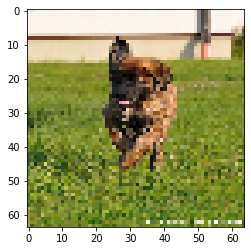

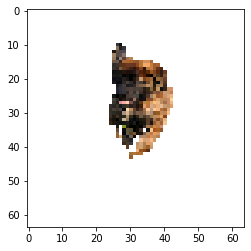

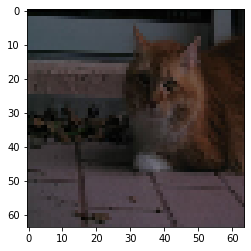

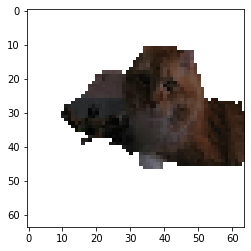

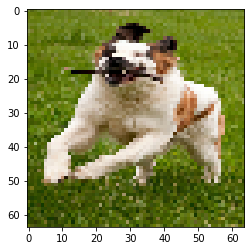

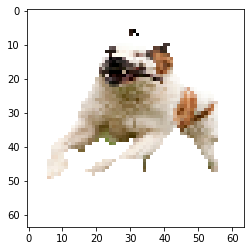

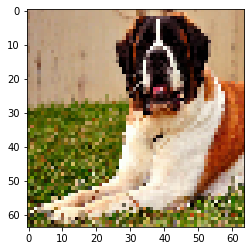

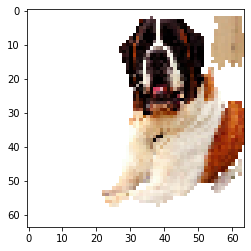

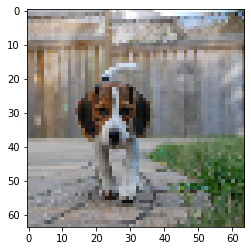

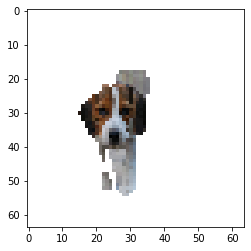

In [22]:
import numpy as np

def mask(pred_mask):
    return np.argmax(pred_mask, axis=-1)[..., tf.newaxis][0]

def create(image, mask):
    for i in range(64):
        for j in range(64):
            if mask[i][j] != 0:
                image[i][j][0] = 255
                image[i][j][1] = 255
                image[i][j][2] = 255

    return image

def predict(i):
    i = tf.image.resize(i, (64, 64))

    pred_mask = model.predict(tf.reshape(i, (1, 64, 64, 3)))
    pred_mask = mask(pred_mask)

    removed = create(i.numpy(), pred_mask)
    return removed

for i in test.take(5):
    plt.imshow(i[0])
    plt.show()

    plt.imshow(predict(i[0]))
    plt.show()


# **Train for Another 10 Epochs**

In [23]:
model.fit(train_dataset, validation_data=test_dataset, epochs=10, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          validation_steps=VALIDATION_STEPS, shuffle=True)

Train for 57 steps, validate for 57 steps
Epoch 1/10
57/57 [==============================] - 66s 1s/step - loss: 0.2750 - accuracy: 0.8861 - val_loss: 0.4035 - val_accuracy: 0.8517
Epoch 2/10
57/57 [==============================] - 66s 1s/step - loss: 0.2730 - accuracy: 0.8868 - val_loss: 0.4004 - val_accuracy: 0.8518
Epoch 3/10
57/57 [==============================] - 66s 1s/step - loss: 0.2665 - accuracy: 0.8891 - val_loss: 0.3760 - val_accuracy: 0.8558
Epoch 4/10
57/57 [==============================] - 66s 1s/step - loss: 0.2681 - accuracy: 0.8885 - val_loss: 0.4787 - val_accuracy: 0.8302
Epoch 5/10
57/57 [==============================] - 66s 1s/step - loss: 0.2593 - accuracy: 0.8919 - val_loss: 0.4091 - val_accuracy: 0.8516
Epoch 6/10
57/57 [==============================] - 66s 1s/step - loss: 0.2529 - accuracy: 0.8938 - val_loss: 0.4585 - val_accuracy: 0.8433
Epoch 7/10
57/57 [==============================] - 66s 1s/step - loss: 0.2461 - accuracy: 0.8964 - val_loss: 0.3842 -

# **Visualising Predictions**

The model is slightly better.


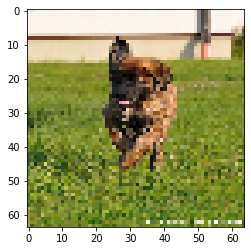

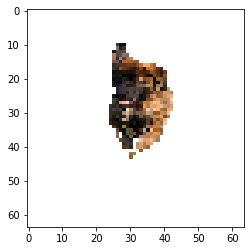

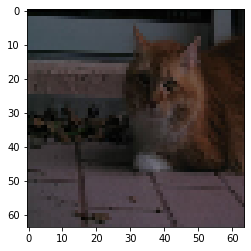

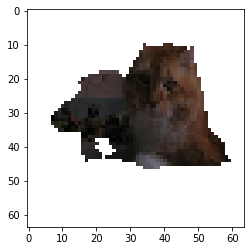

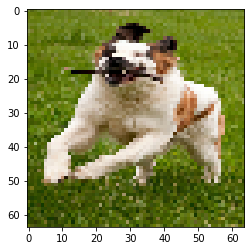

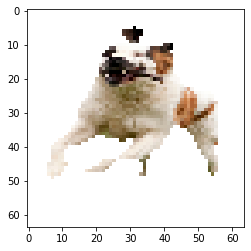

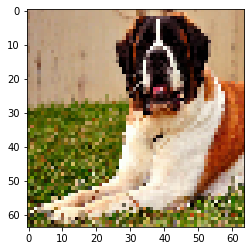

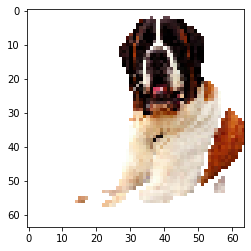

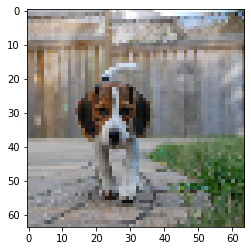

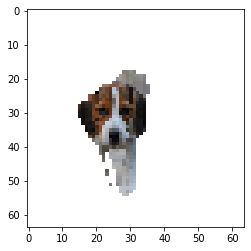

In [24]:
for i in test.take(5):
    plt.imshow(i[0])
    plt.show()

    plt.imshow(predict(i[0]))
    plt.show()
